In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
data = np.load('flatland_train.npz')
X = data['X']
y = data['y']
y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X.reshape(X.shape[0], 50, 50, 1) / 255

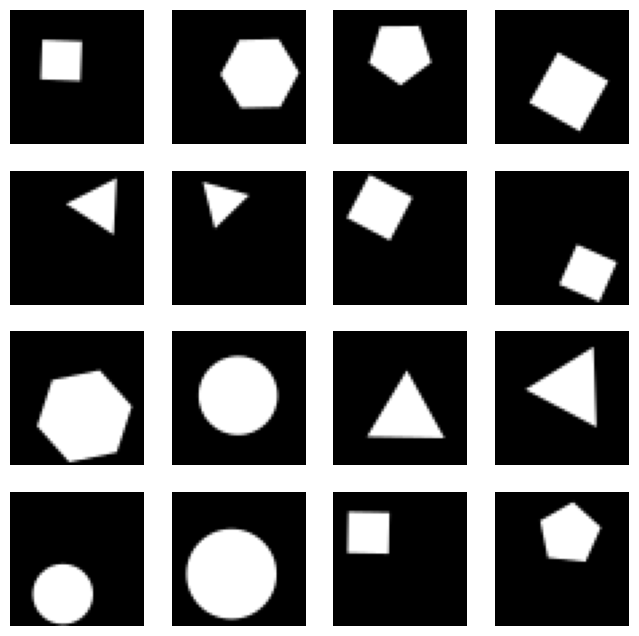

In [3]:
data_generator = ImageDataGenerator()
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

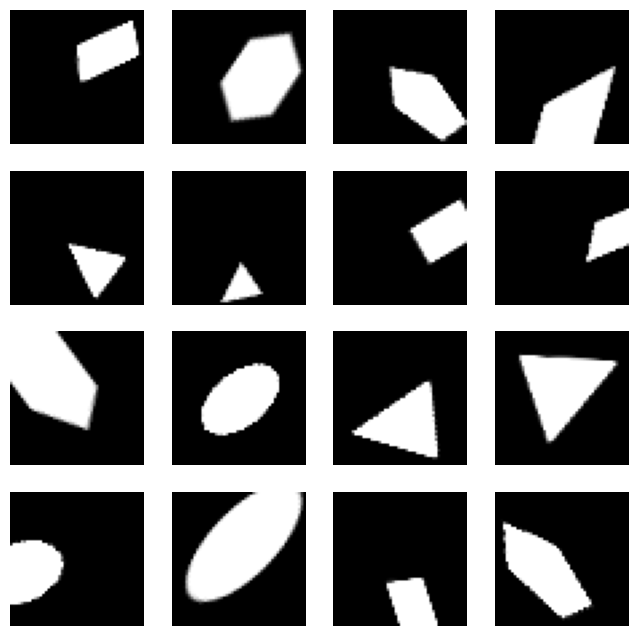

In [4]:
data_generator = ImageDataGenerator(
    rotation_range = 90,
    zoom_range = 0.2,
    shear_range = 45,
    horizontal_flip = 0.5,
    vertical_flip = 0.5,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    channel_shift_range = 0.9,
    validation_split = 0.2
)
data_generator.fit(X)
for X_batch, y_batch in data_generator.flow(X, y, batch_size = 16, shuffle = False):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            ax[i][j].axis('off')
            ax[i][j].imshow(X_batch[i*4 + j].reshape(50, 50), cmap = 'gray')
    plt.show()
    break

In [5]:
X.shape

(10000, 50, 50, 1)

In [6]:
Counter(y)

Counter({2.0: 1868, 4.0: 1761, 3.0: 2137, 1.0: 2853, 0.0: 1381})

In [7]:
#X_train_aug = np.concatenate([X_train, X_train[..., ::-1]])
#y_train_aug = np.concatenate([y_train, y_train])

In [9]:
#TOP MODEL 98 ON ADVANCED

inp = keras.layers.Input(shape = (50, 50, 1));
#out = keras.layers.RandomFlip("horizontal_and_vertical")(inp);
#out = keras.layers.RandomRotation(0.2)(out);
#out = keras.layers.RandomZoom(0.2, 0.2)(out);
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(128, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 32, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/32, epochs = 200, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         7385

250/250 [==============================] - 5s 21ms/step - loss: 0.3790 - accuracy: 0.8913 - val_loss: 0.2770 - val_accuracy: 0.9180
Epoch 35/200
250/250 [==============================] - 5s 21ms/step - loss: 0.3856 - accuracy: 0.8909 - val_loss: 0.2624 - val_accuracy: 0.9180
Epoch 36/200
250/250 [==============================] - 5s 21ms/step - loss: 0.3797 - accuracy: 0.8946 - val_loss: 0.2496 - val_accuracy: 0.9270
Epoch 37/200
250/250 [==============================] - 5s 21ms/step - loss: 0.3633 - accuracy: 0.8983 - val_loss: 0.2551 - val_accuracy: 0.9155
Epoch 38/200
250/250 [==============================] - 5s 22ms/step - loss: 0.3562 - accuracy: 0.8999 - val_loss: 0.2275 - val_accuracy: 0.9305
Epoch 39/200
250/250 [==============================] - 5s 21ms/step - loss: 0.3646 - accuracy: 0.9029 - val_loss: 0.2172 - val_accuracy: 0.9380
Epoch 40/200
250/250 [==============================] - 5s 21ms/step - loss: 0.3531 - accuracy: 0.8980 - val_loss: 0.2202 - val_accuracy: 0.938

250/250 [==============================] - 5s 21ms/step - loss: 0.2759 - accuracy: 0.9315 - val_loss: 0.1790 - val_accuracy: 0.9540
Epoch 91/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2921 - accuracy: 0.9224 - val_loss: 0.1735 - val_accuracy: 0.9485
Epoch 92/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2828 - accuracy: 0.9296 - val_loss: 0.1915 - val_accuracy: 0.9445
Epoch 93/200
250/250 [==============================] - 5s 22ms/step - loss: 0.2654 - accuracy: 0.9336 - val_loss: 0.1621 - val_accuracy: 0.9620
Epoch 94/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2646 - accuracy: 0.9339 - val_loss: 0.1972 - val_accuracy: 0.9400
Epoch 95/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2662 - accuracy: 0.9348 - val_loss: 0.1744 - val_accuracy: 0.9585
Epoch 96/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2592 - accuracy: 0.9325 - val_loss: 0.1719 - val_accuracy: 0.956

250/250 [==============================] - 5s 21ms/step - loss: 0.2425 - accuracy: 0.9401 - val_loss: 0.1618 - val_accuracy: 0.9550
Epoch 147/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2463 - accuracy: 0.9395 - val_loss: 0.1915 - val_accuracy: 0.9490
Epoch 148/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2485 - accuracy: 0.9421 - val_loss: 0.1527 - val_accuracy: 0.9625
Epoch 149/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2444 - accuracy: 0.9409 - val_loss: 0.1630 - val_accuracy: 0.9565
Epoch 150/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2426 - accuracy: 0.9415 - val_loss: 0.1663 - val_accuracy: 0.9580
Epoch 151/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2381 - accuracy: 0.9433 - val_loss: 0.1748 - val_accuracy: 0.9490
Epoch 152/200
250/250 [==============================] - 5s 21ms/step - loss: 0.2477 - accuracy: 0.9413 - val_loss: 0.1598 - val_accuracy:

In [ ]:
pd.DataFrame(hist.history).plot()
model.save('model.h5')

In [8]:
inp = keras.layers.Input(shape = (50, 50, 1));
out = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1])(inp);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu')(out);
out = keras.layers.MaxPooling2D(pool_size=(2, 2))(out);
out = keras.layers.Flatten()(out);
out = keras.layers.Dropout(0.4)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.5)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.6)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.7)(out);
out = keras.layers.Dense(512, activation = 'relu')(out);
out = keras.layers.Dropout(0.8)(out);
out = keras.layers.Dense(128, activation = 'relu')(out);
out = keras.layers.Dropout(0.9)(out);
out = keras.layers.Dense(5, activation = 'softmax')(out);


checkpoint = keras.callbacks.ModelCheckpoint(filepath =  'model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min');

model = keras.models.Model(inputs = inp, outputs = out);
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 3e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']);
model.summary();

hist = model.fit(data_generator.flow(X, y, batch_size = 32, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/32, epochs = 200, callbacks = [checkpoint]);
model = tf.keras.models.load_model('model.h5');

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856 

Epoch 33/200
250/250 [==============================] - 6s 23ms/step - loss: 1.1034 - accuracy: 0.5448 - val_loss: 1.0972 - val_accuracy: 0.5850
Epoch 34/200
250/250 [==============================] - 6s 24ms/step - loss: 1.1543 - accuracy: 0.5163 - val_loss: 1.0346 - val_accuracy: 0.6035
Epoch 35/200
250/250 [==============================] - 6s 24ms/step - loss: 1.0805 - accuracy: 0.5508 - val_loss: 0.9979 - val_accuracy: 0.6325
Epoch 36/200
250/250 [==============================] - 6s 24ms/step - loss: 1.0805 - accuracy: 0.5441 - val_loss: 0.9729 - val_accuracy: 0.6340
Epoch 37/200
250/250 [==============================] - 6s 24ms/step - loss: 1.0942 - accuracy: 0.5420 - val_loss: 0.9493 - val_accuracy: 0.6480
Epoch 38/200
250/250 [==============================] - 6s 24ms/step - loss: 1.0548 - accuracy: 0.5684 - val_loss: 0.9052 - val_accuracy: 0.7160
Epoch 39/200
250/250 [==============================] - 6s 23ms/step - loss: 1.0448 - accuracy: 0.5700 - val_loss: 1.0520 - val_ac

250/250 [==============================] - 5s 22ms/step - loss: 0.8074 - accuracy: 0.7283 - val_loss: 0.6593 - val_accuracy: 0.8100
Epoch 90/200
250/250 [==============================] - 5s 22ms/step - loss: 0.7738 - accuracy: 0.7420 - val_loss: 0.7940 - val_accuracy: 0.6680
Epoch 91/200
250/250 [==============================] - 5s 22ms/step - loss: 0.7610 - accuracy: 0.7418 - val_loss: 0.6309 - val_accuracy: 0.8010
Epoch 92/200
250/250 [==============================] - 5s 22ms/step - loss: 0.7950 - accuracy: 0.7266 - val_loss: 0.6355 - val_accuracy: 0.8215
Epoch 93/200
250/250 [==============================] - 5s 22ms/step - loss: 0.7964 - accuracy: 0.7381 - val_loss: 0.6240 - val_accuracy: 0.8270
Epoch 94/200
250/250 [==============================] - 5s 22ms/step - loss: 0.8189 - accuracy: 0.7270 - val_loss: 0.6872 - val_accuracy: 0.7315
Epoch 95/200
250/250 [==============================] - 5s 21ms/step - loss: 0.7765 - accuracy: 0.7405 - val_loss: 0.6152 - val_accuracy: 0.833

250/250 [==============================] - 5s 21ms/step - loss: 0.7337 - accuracy: 0.7694 - val_loss: 0.5137 - val_accuracy: 0.8730
Epoch 146/200
250/250 [==============================] - 5s 21ms/step - loss: 0.7001 - accuracy: 0.7834 - val_loss: 0.5115 - val_accuracy: 0.8770
Epoch 147/200
250/250 [==============================] - 5s 21ms/step - loss: 0.7022 - accuracy: 0.7853 - val_loss: 0.6357 - val_accuracy: 0.7860
Epoch 148/200
250/250 [==============================] - 5s 22ms/step - loss: 0.6868 - accuracy: 0.7943 - val_loss: 0.5276 - val_accuracy: 0.8620
Epoch 149/200
250/250 [==============================] - 5s 22ms/step - loss: 0.7024 - accuracy: 0.7866 - val_loss: 0.6038 - val_accuracy: 0.8015
Epoch 150/200
250/250 [==============================] - 5s 22ms/step - loss: 0.8000 - accuracy: 0.7383 - val_loss: 0.6124 - val_accuracy: 0.8120
Epoch 151/200
250/250 [==============================] - 5s 21ms/step - loss: 0.7323 - accuracy: 0.7730 - val_loss: 0.5735 - val_accuracy:

In [ ]:
model = tf.keras.models.load_model('model.h5');
hist = model.fit(data_generator.flow(X, y, batch_size = 32, subset = 'training'),
                 validation_data = data_generator.flow(X, y, batch_size = 8, subset = 'validation'),
                 steps_per_epoch = len(X)*0.8/32, epochs = 50, callbacks = [checkpoint]);